# Indice de confiance des consommateurs 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import sys
sys.path.append("../scripts/")

# librairies perso
from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients

In [2]:
conf = pd.read_csv("../data/indiceDeConfiance.csv")
conf = conf[["TIME", "Value", "LOCATION"]]
masque = (conf["LOCATION"] == "NLD") | (conf["LOCATION"] == "LUX") | (conf["LOCATION"] == "BEL")
conf = conf[masque]
conf["horodate"] = pd.to_datetime(conf["TIME"])
conf.drop("TIME", axis = 1, inplace = True)
masque2 = (conf["horodate"] >= pd.to_datetime("2021-01-01")) & (conf["horodate"] <= pd.to_datetime("2023-02-01"))
conf = conf[masque2]
conf_by_country = conf.groupby("LOCATION")
conf, conf2, conf3 = conf_by_country.get_group("BEL").copy().reset_index(), conf_by_country.get_group("NLD").copy().reset_index(), conf_by_country.get_group("LUX").copy().reset_index()

In [3]:
conf["Value"] = (conf["Value"] + conf2["Value"] + conf3["Value"])/3
conf.drop(["index", "LOCATION"], axis = 1, inplace = True)
conf = conf.set_index("horodate")
conf = conf.asfreq('D')
conf['Value'] = conf['Value'].fillna(method='ffill')
conf = conf.iloc[:-1,:]

In [4]:
data = pd.read_csv("../data/dataset_modify").drop("Unnamed: 0", axis = 1)
data["horodate"] = pd.to_datetime(data["horodate"])
data = pd.merge(data, conf, on = ["horodate"], how = "left")

In [5]:
clients = group_by_clients(data)
n = len(clients)

In [6]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["forecasted_consumption","Value"], ["real_consumption"])

In [7]:
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [8]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

In [9]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

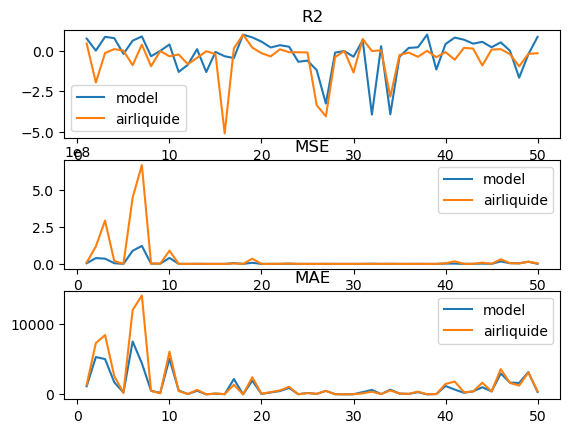

In [10]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

In [11]:
def display_feat_imp(models):
    k = len(models)
    feat_imp_reg = 0
    for model in models: 
        feat_imp_reg += model.coef_[0]
    feat_imp_reg /= k
    feat_importance = pd.DataFrame(columns = ["Feature Name", "Feature Importance"])
    feat_importance["Feature Name"] = pd.Series(model.feature_names_in_)
    feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
    feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

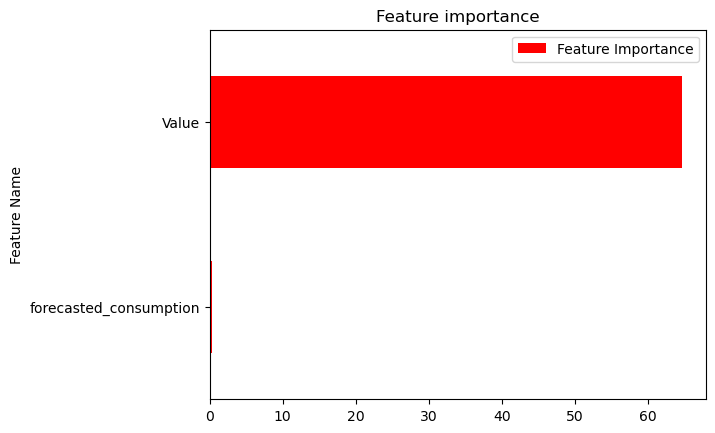

In [12]:
display_feat_imp(models)